<a href="https://colab.research.google.com/github/KyoungmiKwon/trainingAtAiffel/blob/main/DL19_MainQuest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

`MainQuest`

`TF-idf, Voca_size 변경, ML` 실험

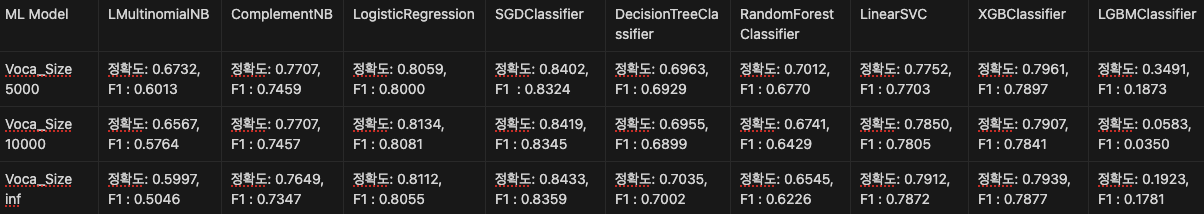

`Word2Vec, Voca_size 10,000` 실험       

> ML (ML 파라미터는 tf-idf로 실험 할 때와 동일)  
>> LogisticRegression 정확도: 0.7302, F1 Score: 0.7289   
>> SGDClassifier 정확도: 0.7284, F1 Score: 0.7051    
>> DecisionTreeClassifier 정확도: 0.6322, F1 Score: 0.6297   
>> RandomForestClassifier 정확도: 0.6790, F1 Score: 0.6551   
>> LinearSVC 정확도: 0.7573, F1 Score: 0.7497           
>> XGBClassifier 정확도: 0.7427, F1 Score: 0.7233           
>> LGBMClassifier 정확도: 0.2293, F1 Score: 0.2319          


> DL        
>> Dense => Accuracy: 0.7012, F1-score: 0.6767       
>> RNN => Accuracy: 0.7752, F1-score: 0.7654

1. 경제성을 고려하였을 때, Voca의 숫자가 큰 것이 좋은 것만은 아니다.    
2. 머신러닝 중에 앙상블 모델이 언제나 좋은 성능을 내는 것은 아니다.  
3. 딥러닝 모델이 머신러닝 모델보다 언제나 좋은 성능을 내는 것은 아니다.
4. 문맥을 고려한 W2V는 딥러닝 모델 또한 이전 시점을 기억하고 현재시점을 처리 하는 (앞뒤를 살피는) 모델이 성능이 더 좋았다. 즉, 데이터의 특징에 따라 그것을 반영 해 줄 수 있는 모델이 성능이 좋은 거 같다.

In [ ]:
!pip install gensim

In [37]:
from tensorflow.keras.datasets import reuters
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [4]:
import tensorflow
import matplotlib
import seaborn
import numpy
import pandas
import sklearn

print(tensorflow.__version__)
print(matplotlib.__version__)
print(seaborn.__version__)
print(numpy.__version__)
print(pandas.__version__)
print(sklearn.__version__)

2.18.0
3.10.0
0.13.2
1.26.4
2.2.2
1.6.1


In [38]:
## Load the Reuters dataset
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=10000, # 빈도수 기준 상위 몇 개 단어를 사용할지 정의
                                                         test_split=0.2)
print('훈련 샘플의 수: {}'.format(len(x_train)))
print('테스트 샘플의 수: {}'.format(len(x_test)))

## Word Decording
word_index = reuters.get_word_index(path="reuters_word_index.json")
index_to_word = { index+3 : word for word, index in word_index.items()}

for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
  index_to_word[index]=token


decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)

x_train = decoded
print(len(x_train))

# %%
decoded_test = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded_test.append(t)

x_test = decoded_test
print(len(x_test))


훈련 샘플의 수: 8982
테스트 샘플의 수: 2246
8982
2246


In [ ]:
"""
벡터화 하기
"""
# %%
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
# CountVectorizer를 사용하여 단어 카운트 행렬을 생성
count_vectorizer = CountVectorizer()
x_train_dtm = count_vectorizer.fit_transform(x_train)
print(x_train_dtm.shape)  # (샘플 수, 단어 수)

# TfidfTransformer를 사용하여 TF-IDF 행렬을 생성
tfidf_transformer = TfidfTransformer()
x_train_tfidf = tfidf_transformer.fit_transform(x_train_dtm)
print(x_train_tfidf.shape)  # (샘플 수, 단어 수)

# test
x_test_dtm = count_vectorizer.transform(x_test) #테스트 데이터를 DTM으로 변환
x_test_tfidf = tfidf_transformer.transform(x_test_dtm) #DTM을 TF-IDF 행렬로 변환

In [21]:
from sklearn.naive_bayes import MultinomialNB #다항분포 나이브 베이즈 모델
from sklearn.naive_bayes import ComplementNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score #정확도 계산 및 F1 Score 계산

In [ ]:
models = [
    MultinomialNB(),
    ComplementNB(),
    LogisticRegression(max_iter=1000, penalty='l2', C=10000), # C는 정규화 강도, 작을수록 강한 정규화
    SGDClassifier(max_iter=1000, tol=1e-3),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=5, random_state=0),
    LinearSVC(C=1000, penalty='l1', max_iter=1000, dual=False), # C는 정규화 강도, 작을수록 강한 정규화 # dual=False는 l1 패널티를 사용할 때 필요
    XGBClassifier(n_estimators=100, max_depth=5, eval_metric='mlogloss'),
    LGBMClassifier()
    ]

from sklearn.metrics import accuracy_score, f1_score #정확도 계산 및 F1 Score 계산
results = {}
for model in models:
    model.fit(x_train_tfidf, y_train)
    predicted = model.predict(x_test_tfidf)
    accuracy = accuracy_score(y_test, predicted)
    F1_score = f1_score(y_test, predicted, average='weighted') # macro: 단순평균, weighted: 각 클래스에 속하는 표본의 개수로 가중평균
    print(f"{model.__class__.__name__} 정확도: {accuracy:.4f}, F1 Score: {F1_score:.4f}")

### 딥러닝 모델과 비교하기

#### ML

In [15]:
# 벡터화 W2V방법
from gensim.models import Word2Vec

# 우선 문장을 토큰화 시킵시다 띄어쓰기 기반으로 해볼게요! -> # 위에서 DTM만들때는 왜 안해줬냐! -> CountVectorizer에서 띄어쓰기 기반 토큰화가 내장되있음
x_train_tokenized = [sentence.split() for sentence in x_train]
x_test_tokenized = [sentence.split() for sentence in x_test]

# Word Embedding
model = Word2Vec(sentences = x_train_tokenized,
                 vector_size = 256,
                 window = 5,
                 min_count = 5,
                 workers = 4,
                 sg = 0 # CBow
                 )


In [16]:
model_result = model.wv.most_similar('man')
print(model_result)

[('gordon', 0.8483933210372925), ('erbynn', 0.8403511643409729), ('glenn', 0.8340560793876648), ('okla', 0.8286195397377014), ('don', 0.8250759243965149), ('recorders', 0.8239143490791321), ('businessman', 0.8235197067260742), ('rica', 0.8226074576377869), ('simon', 0.8211196660995483), ('arnold', 0.817758321762085)]


In [17]:
# Vectorization

# 학습된 Word2Vec 모델
w2v_model = model

# 정보 손실을 최소화하는 문장 벡터화 코드
def vectorize_sentence(sentence_tokens, model, max_len):
    """
    주어진 토큰화된 문장을 Word2Vec 단어 벡터 시퀀스로 변환하고,
    max_len에 맞춰 패딩 또는 트렁케이션을 수행하여 정보 손실을 최소화합니다.

    Args:
        sentence_tokens (list): 토큰화된 단어들의 리스트
        model (gensim.models.Word2Vec): 학습된 Word2Vec 모델
        max_len (int): 모든 문장의 시퀀스 길이를 맞출 최대 길이

    Returns:
        np.array: (max_len, vector_size) 형태의 문장 벡터 시퀀스
    """
    vecs = []
    for word in sentence_tokens:
        if word in model.wv:
            vecs.append(model.wv[word])
        else:
            # OOV 단어는 0 벡터로 처리하여 정보 손실을 최소화 (단어 자체의 정보는 없지만,
            # 시퀀스 길이가 유지되고 해당 위치에 "알 수 없음"을 표시)
            vecs.append(np.zeros(model.vector_size))

    # 트렁케이션 (max_len보다 길면 잘라냄)
    if len(vecs) > max_len:
        vecs = vecs[:max_len]
    # 패딩 (max_len보다 짧으면 0 벡터로 채움)
    elif len(vecs) < max_len:
        vecs += [np.zeros(model.vector_size)] * (max_len - len(vecs))

    return np.array(vecs)



# 벡터화 적용
MAX_SEQUENCE_LENGTH = 100
x_train_w2v = np.array([vectorize_sentence(s, w2v_model, max_len=MAX_SEQUENCE_LENGTH) for s in x_train_tokenized])
x_test_w2v = np.array([vectorize_sentence(s, w2v_model, max_len=MAX_SEQUENCE_LENGTH) for s in x_test_tokenized])

x_train_w2v.shape, x_test_w2v.shape


((8982, 100, 256), (2246, 100, 256))

In [18]:
# w2v로 모델 학습 하기

# Word2Vec 임베딩 시퀀스: (8982, 100, 256)
x_w2v_seq_train = x_train_w2v
x_w2v_seq_test = x_test_w2v
# 평균 풀링 → (8982, 256)
x_w2v_avg_train = np.mean(x_w2v_seq_train, axis=1)
x_w2v_avg_test = np.mean(x_w2v_seq_test, axis=1)
print(x_w2v_avg_train.shape)  # (8982, 256)

(8982, 256)


In [ ]:
models = [
    # MultinomialNB(), # Removed because it cannot handle negative values
    # ComplementNB(),
    LogisticRegression(max_iter=1000, penalty='l2', C=10000), # C는 정규화 강도, 작을수록 강한 정규화
    SGDClassifier(max_iter=1000, tol=1e-3),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=5, random_state=0),
    LinearSVC(C=1000, penalty='l1', max_iter=1000, dual=False), # C는 정규화 강도, 작을수록 강한 정규화 # dual=False는 l1 패널티를 사용할 때 필요
    XGBClassifier(n_estimators=100, max_depth=5, eval_metric='mlogloss'),
    LGBMClassifier()
    ]

results = {}
for model in models:
    model.fit(x_w2v_avg_train, y_train)
    predicted = model.predict(x_w2v_avg_test)
    accuracy = accuracy_score(y_test, predicted)
    F1_score = f1_score(y_test, predicted, average='weighted') # macro: 단순평균, weighted: 각 클래스에 속하는 표본의 개수로 가중평균
    print(f"{model.__class__.__name__} 정확도: {accuracy:.4f}, F1 Score: {F1_score:.4f}")

#### DL - Dense NN

In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Flatten, Dense, Dropout, LSTM, Dense, Dropout

input_shape = x_train_w2v.shape[1:]
output_shape = len(set(y_train))

model_dense = models.Sequential()

model_dense.add(layers.Input(shape=(input_shape), name='input_layer'))
model_dense.add(layers.Dense(512, activation='relu', name='hidden_layer_1'))
model_dense.add(layers.Dropout(0.3, name='dropout_layer_1'))
model_dense.add(layers.Dense(128, activation='relu', name='hidden_layer_2'))
model_dense.add(layers.Dropout(0.3, name='dropout_layer_2'))
model_dense.add(layers.Flatten(name='flatten_layer'))  # Add Flatten layer here
model_dense.add(layers.Dense(output_shape, activation='softmax', name='output_layer'))

model_dense.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_dense.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_layer_1 (Dense)          │ (None, 100, 512)       │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer_1 (Dropout)       │ (None, 100, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_2 (Dense)          │ (None, 100, 128)       │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer_2 (Dropout)       │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_layer (Flatten)         │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 46)             │       588,846 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 786,094 (3.00 MB)

 Trainable params: 786,094 (3.00 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
from tensorflow.keras import callbacks
from tensorflow.keras import utils

early_stopping_cb = callbacks.EarlyStopping(patience=10,
                                            monitor='val_accuracy',
                                            restore_best_weights=True)

history = model_dense.fit(x_train_w2v, y_train,
                    epochs=100,
                    batch_size=64,
                    validation_split = 0.2,
                    callbacks=[early_stopping_cb],
                    verbose=1)

Epoch 1/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.5147 - loss: 2.0113 - val_accuracy: 0.7101 - val_loss: 1.3197
Epoch 2/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.7566 - loss: 0.9342 - val_accuracy: 0.7195 - val_loss: 1.1987
Epoch 3/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8871 - loss: 0.4345 - val_accuracy: 0.7017 - val_loss: 1.3585
Epoch 4/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9398 - loss: 0.2395 - val_accuracy: 0.7168 - val_loss: 1.5311
Epoch 5/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9474 - loss: 0.2220 - val_accuracy: 0.7190 - val_loss: 1.5870
Epoch 6/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9570 - loss: 0.1751 - val_accuracy: 0.7095 - val_loss: 1.5035
Epoch 7/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9588 - loss: 0.1641 - val_accuracy: 0.7151 - val_loss: 1.5721
Epoch 8/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9606 - loss: 0.1455 - 

In [47]:
y_pred_proba = model_dense.predict(x_test_w2v)
y_pred = np.argmax(y_pred_proba, axis=1)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {acc:.4f}")
print(f"F1-score: {f1:.4f}")

71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Accuracy: 0.7012
F1-score: 0.6767


#### DL - RNN

In [48]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Flatten, Dense, Dropout, LSTM, Dense, Dropout


model_rnn = Sequential()
model_rnn.add(layers.LSTM(128, input_shape=input_shape))
model_rnn.add(layers.Dropout(0.3))

model_rnn.add(layers.Dense(64, activation='relu'))
model_rnn.add(layers.Dropout(0.3))

model_rnn.add(layers.Dense(output_shape, activation='softmax'))

model_rnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_rnn.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 46)             │         2,990 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 208,366 (813.93 KB)

 Trainable params: 208,366 (813.93 KB)

 Non-trainable params: 0 (0.00 B)

In [49]:
from tensorflow.keras import callbacks
from tensorflow.keras import utils

early_stopping_cb = callbacks.EarlyStopping(patience=10,
                                            monitor='val_accuracy',
                                            restore_best_weights=True)

history = model_rnn.fit(x_train_w2v, y_train,
                    epochs=100,
                    batch_size=64,
                    validation_split = 0.2,
                    callbacks=[early_stopping_cb],
                    verbose=1)

Epoch 1/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.3563 - loss: 2.8035 - val_accuracy: 0.5854 - val_loss: 1.6860
Epoch 2/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5718 - loss: 1.7498 - val_accuracy: 0.6683 - val_loss: 1.4919
Epoch 3/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.6472 - loss: 1.5314 - val_accuracy: 0.6834 - val_loss: 1.3508
Epoch 4/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6606 - loss: 1.4377 - val_accuracy: 0.6850 - val_loss: 1.3012
Epoch 5/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6779 - loss: 1.3491 - val_accuracy: 0.6761 - val_loss: 1.3534
Epoch 6/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7003 - loss: 1.2605 - val_accuracy: 0.7195 - val_loss: 1.1684
Epoch 7/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7167 - loss: 1.1903 - val_accuracy: 0.7412 - val_loss: 1.1331
Epoch 8/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7357 - loss: 1.1020 - 

In [50]:
y_pred_proba = model_rnn.predict(x_test_w2v)
y_pred = np.argmax(y_pred_proba, axis=1)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {acc:.4f}")
print(f"F1-score: {f1:.4f}")

71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Accuracy: 0.7752
F1-score: 0.7654
